Using device: cuda


100%|██████████| 562M/562M [00:06<00:00, 89.9MB/s]


Train/Val/Test sizes: 628138 69794 116323

=== Training regime: fc ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


Epoch 1/3 | Train loss: 0.8059, acc: 0.763 | Val loss: 0.6306, acc: 0.799
Epoch 2/3 | Train loss: 0.6241, acc: 0.798 | Val loss: 0.5996, acc: 0.807
Epoch 3/3 | Train loss: 0.5974, acc: 0.804 | Val loss: 0.5908, acc: 0.805
Training time: 4068.0s
Test loss: 0.5975, Test acc: 0.801

Classification Report:
              precision    recall  f1-score   support

           0      0.623     0.872     0.727      5778
           1      0.719     0.710     0.714      6330
           2      0.900     0.912     0.906      5869
           3      0.959     0.950     0.955      5969
           4      0.957     0.880     0.917      5619
           5      0.846     0.897     0.871      5190
           6      0.946     0.940     0.943      5705
           7      0.965     0.952     0.958      6139
           8      0.870     0.972     0.918      5633
           9      0.877     0.957     0.915      5686
          10      0.774     0.893     0.829      1062
          11      0.855     0.690     0.763    

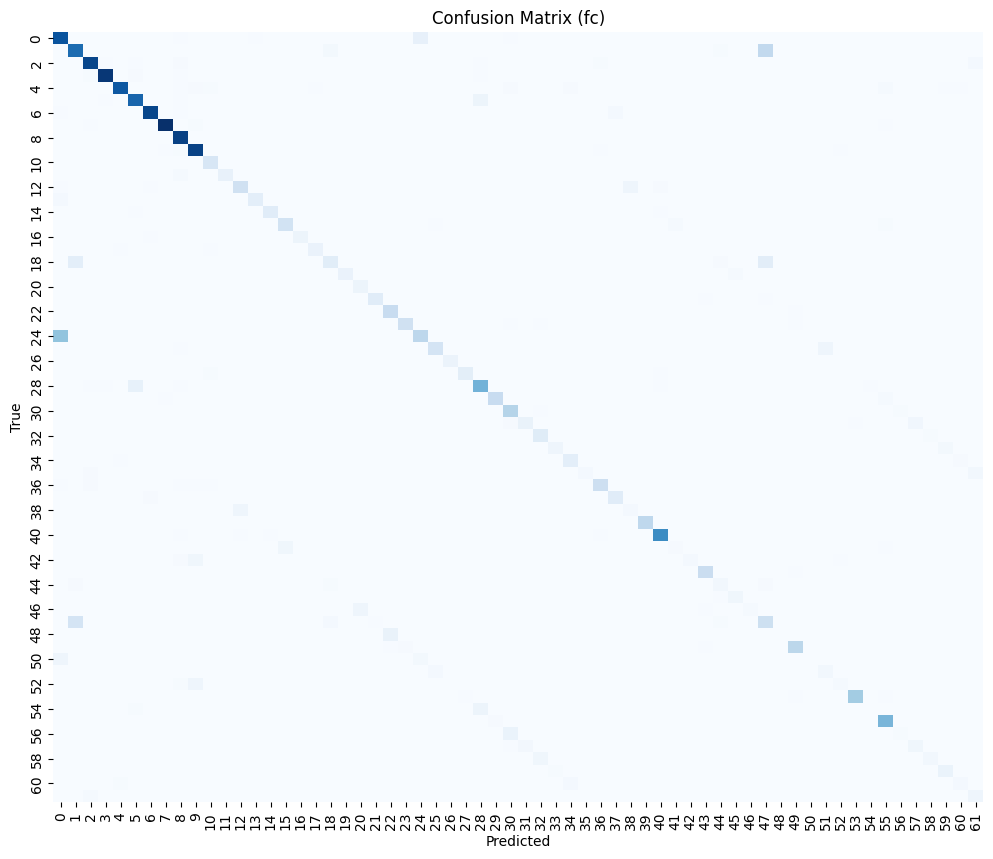

Trainable Params: 0.03M

=== Training regime: layer4 ===
Epoch 1/3 | Train loss: 0.3949, acc: 0.858 | Val loss: 0.3417, acc: 0.875
Epoch 2/3 | Train loss: 0.3322, acc: 0.875 | Val loss: 0.3342, acc: 0.876
Epoch 3/3 | Train loss: 0.3065, acc: 0.883 | Val loss: 0.3234, acc: 0.881
Training time: 4068.3s
Test loss: 0.3273, Test acc: 0.878

Classification Report:
              precision    recall  f1-score   support

           0      0.689     0.855     0.763      5778
           1      0.698     0.908     0.789      6330
           2      0.967     0.975     0.971      5869
           3      0.992     0.997     0.995      5969
           4      0.980     0.981     0.981      5619
           5      0.958     0.952     0.955      5190
           6      0.984     0.977     0.980      5705
           7      0.990     0.996     0.993      6139
           8      0.986     0.992     0.989      5633
           9      0.926     0.987     0.955      5686
          10      0.963     0.983     0.973 

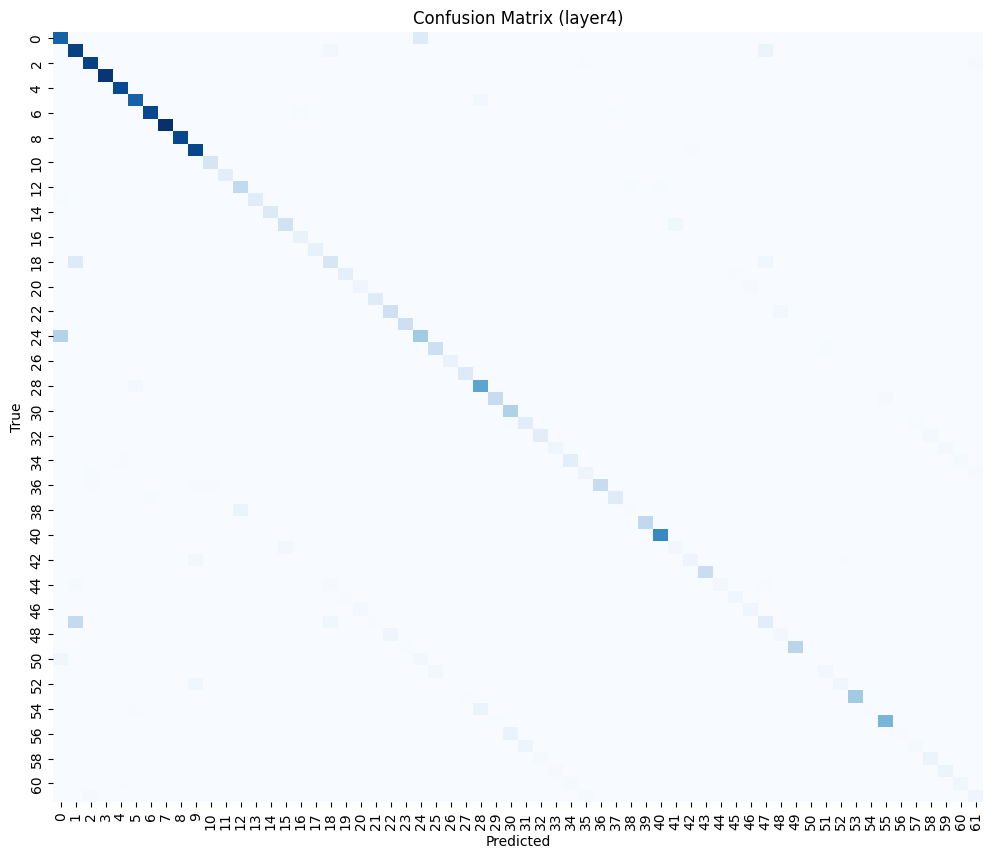

Trainable Params: 8.43M

=== Training regime: all ===
Epoch 1/3 | Train loss: 0.3903, acc: 0.862 | Val loss: 0.3345, acc: 0.877
Epoch 2/3 | Train loss: 0.3215, acc: 0.879 | Val loss: 0.3144, acc: 0.882


In [ ]:
# ============================================================
# Task 2 — Fine-Tuning ResNet-18 on EMNIST (byclass)
# ============================================================
# This script demonstrates how to fine-tune a pre-trained ResNet-18 model
# on the EMNIST dataset using PyTorch. It includes three training regimes:
# 1. Linear probing (only the final layer is trained)
# 2. Partial unfreezing (last block + final layer)
# 3. Full fine-tuning (all layers are trained)
# The script also evaluates the model and visualizes results.
# ============================================================
# Author: Hailemariam Mersha
# Date: 2024-10-04
# Email: hbm9834@nyu.edu
# ============================================================
!pip install torch torchvision scikit-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# -------------------------
# Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# Preprocessing for EMNIST
# -------------------------
# EMNIST images need: rotate -90°, flip horizontal, resize 224, normalize with ImageNet stats
transform = transforms.Compose([
    transforms.Lambda(lambda x: transforms.functional.rotate(x, -90)),  # rotate -90
    transforms.Lambda(lambda x: transforms.functional.hflip(x)),       # flip horizontal
    transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

# -------------------------
# Dataset & Splits
# -------------------------
dataset = datasets.EMNIST(root="./data", split="byclass", train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root="./data", split="byclass", train=False, download=True, transform=transform)

num_classes = 62  # EMNIST byclass
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print("Train/Val/Test sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

# -------------------------
# Build ResNet18
# -------------------------
def build_resnet(freeze_until="fc"):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if freeze_until == "fc":  # Linear probe
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    elif freeze_until == "layer4":  # Partial unfreeze (last block + FC)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    elif freeze_until == "all":  # Full fine-tune
        for param in model.parameters():
            param.requires_grad = True

    return model.to(device)

# -------------------------
# Training & Evaluation
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

            preds_all.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    return total_loss / total, correct / total, preds_all, labels_all

# -------------------------
# Run Experiment
# -------------------------
def run_experiment(freeze_until="fc", epochs=3, lr=0.001):
    print(f"\n=== Training regime: {freeze_until} ===")
    model = build_resnet(freeze_until)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    start_time = time.time()
    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train loss: {tr_loss:.4f}, acc: {tr_acc:.3f} | Val loss: {val_loss:.4f}, acc: {val_acc:.3f}")

    elapsed = time.time() - start_time
    print(f"Training time: {elapsed:.1f}s")

    # Final test eval
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion)
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.3f}")

    print("\nClassification Report:")
    print(classification_report(labels, preds, digits=3))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix ({freeze_until})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Efficiency
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Params: {params/1e6:.2f}M")

    return model, (train_losses, val_losses, train_accs, val_accs)

# -------------------------
# Try different regimes
# -------------------------
# 1. Linear probe
model_fc, _ = run_experiment(freeze_until="fc", epochs=3, lr=0.001)

# 2. Partial unfreeze
model_l4, _ = run_experiment(freeze_until="layer4", epochs=3, lr=0.0005)

# 3. Full fine-tune
model_all, _ = run_experiment(freeze_until="all", epochs=3, lr=0.0001)
print("Experiment completed.")
print("Hailemariam Mersha")
print("Netid: hbm9834")